In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langgraph.graph import END, START, StateGraph, MessagesState # It will always add latest message to the messages list
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode #To convert our tool to a langgraph node
from typing import Literal

In [4]:
@tool(parse_docstring=False)
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."

In [5]:
get_weather.invoke(input={"location": "munich"})

"It's 15 degrees Celsius and cloudy."

In [6]:
tools = [get_weather]
model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [7]:
model.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 45, 'total_tokens': 56, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'stop', 'logprobs': None}, id='run-28f3ed41-aacd-4407-9e16-c287f5e36398-0', usage_metadata={'input_tokens': 45, 'output_tokens': 11, 'total_tokens': 56, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [8]:
model.invoke("How is the weather in munich?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xITGpFOdbNzScig80W2IR3dB', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5714913d-8870-41f0-9c55-aaa7660db01f-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_xITGpFOdbNzScig80W2IR3dB', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens': 16, 'total_tokens': 68, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reaso

In [9]:
def call_model(state: MessagesState):
    messages = state["messages"] # Extracting the messages
    response = model.invoke(messages) #pass all the messages to the model
    return {"messages": [response]} # Only returns new response cuz we use the reducer function (check code of MessagesState called
    # add_messages) which is responsible for adding the response from the model to the messages list


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"] #extract emssages
    last_message = messages[-1] # Check if last messsage of the list has a tool called attribute
    if last_message.tool_calls: # If thats the case, we want to return string tool to make use of tool calling otherwise return END
        return "tools" 
    return END # Langgraph workflow is done

In [10]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [11]:
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent") # We always want to route back to the agent node cuz agent is always responsible for
# creating human like answer using the tool

In [12]:
graph = workflow.compile()


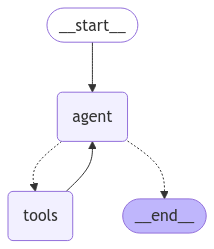

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [15]:
from langchain_core.messages import HumanMessage

messages1 = [HumanMessage(content="Hello, how are you?")]
messages2 = [HumanMessage(content="How is the weather in munich?")]

In [16]:
graph.invoke({"messages": messages1})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='5c3dd6e2-cffa-432a-95d0-332e89926b54'),
  AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 50, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-2034911f-643a-4c6a-94b1-e6e87ec01d80-0', usage_metadata={'input_tokens': 50, 'output_tokens': 31, 'total_tokens': 81, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [17]:
graph.invoke({"messages": messages2})

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='168c5a24-11cf-49dd-b075-01cf33a1df3b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nrHYp26hPQJGykYyuQMkTKCT', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a8600e3e-9ccb-4dfb-9868-e326015f8b00-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_nrHYp26hPQJGykYyuQMkTKCT', 'type': 'tool_call'}], usage_metadata={

In [18]:
# It didnt understand cuz theres no memory
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    }
)

{'messages': [HumanMessage(content='What would you recommend to do in that city than?', additional_kwargs={}, response_metadata={}, id='4b049cd4-e466-43d4-92bd-e6385d40589e'),
  AIMessage(content='Could you please specify which city you are referring to?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 55, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-859f7720-f648-4513-96f5-8ad06ef22acb-0', usage_metadata={'input_tokens': 55, 'output_tokens': 12, 'total_tokens': 67, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

### Add Memory to chatbot

In [19]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
# This is the simplest which stores everything in memory and it must ONLY be used for debugging and testing purposes 
#This is mentioned by LC team themselves
# For production use cases we recommend installing langgraph-checkpoint-postgres and using PostgresSaver / AsyncPostgresSaver.

In [20]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=checkpointer)

In [21]:
# Since we used memory checkpointer, we now have separate users by the config thread_id. 
# I'm not sure if it should be called "thread_id" but the integer 1 represents a user so if u change it, it will be considered
#as a different user

graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in munich?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='7053f66d-d344-4ebe-90ce-edc21a843933'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LXwwDUfU5J5rFa8x6fzFUiXK', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b7f82c78-18b6-4a82-868f-d32458c54011-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_LXwwDUfU5J5rFa8x6fzFUiXK', 'type': 'tool_call'}], usage_metadata={

In [ ]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    },
    config={"configurable": {"thread_id": 2}},
)

{'messages': [HumanMessage(content='What would you recommend to do in that city than?', additional_kwargs={}, response_metadata={}, id='f1546087-a885-4279-b416-8055cc45a666'),
  AIMessage(content="Could you please specify which city you're referring to?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 55, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-71217c18-7ccc-4bf5-ba0b-1e295591b9d9-0', usage_metadata={'input_tokens': 55, 'output_tokens': 12, 'total_tokens': 67, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

: 